In [1]:
# dependencies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from numpy import sqrt

from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import Holt 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [2]:
#reading data from file
train = pd.read_csv(r'C:/Testing/DA/predictFutureSalesClean.csv')
test = pd.read_csv('C:/Testing/DA/test.csv')
sample_submission = pd.read_csv('C:/Testing/DA/sample_submission.csv')
items = pd.read_csv('C:/Testing/DA/items.csv')
item_cats = pd.read_csv('C:/Testing/DA/item_categories.csv')
shops = pd.read_csv('C:/Testing/DA/shops.csv')

In [3]:
#checking the data types of train
train.dtypes

Unnamed: 0              int64
date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
shop_name              object
item_name              object
item_category_id        int64
Required                 bool
item_category_name     object
date_month              int64
date_year               int64
total_sales           float64
dtype: object

## Feature Engineering 

In [4]:
#add more columns for feature engineering by adding the week of the year, week of the historical data, name of the day and the day
all_data = train
all_data['date'] = pd.to_datetime(all_data.date, format='%Y.%m.%d')
all_data['date_week'] = all_data.date.dt.week
all_data['dayofweek_name'] = all_data.date.dt.day_name()
all_data['dayofweek_no'] = all_data.date.dt.dayofweek 
all_data['wrk_week'] = np.where(all_data['date_year']==2013, all_data['date_week'], np.where(all_data['date_year']==2014, all_data['date_week']+52, all_data['date_week']+104))

In [5]:
all_data

,Unnamed: 0,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,Required,item_category_name,date_month,date_year,total_sales,date_week,dayofweek_name,dayofweek_no,wrk_week
0,0,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,True,Кино - Blu-Ray,1,2013,999.0,1,Wednesday,2,1
1,1,2013-01-03,0,25,2574,399.0,2.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства,1,2013,798.0,1,Thursday,3,1
2,2,2013-01-05,0,25,2574,399.0,1.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства,1,2013,399.0,1,Saturday,5,1
3,3,2013-01-07,0,25,2574,399.0,1.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства,1,2013,399.0,2,Monday,0,2
4,4,2013-01-08,0,25,2574,399.0,2.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства,1,2013,798.0,2,Tuesday,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442559,1442559,2015-10-10,33,25,7409,299.0,1.0,"Москва ТРК ""Атриум""",V/A Nu Jazz Selection (digipack),55,True,Музыка - CD локального производства,10,2015,299.0,41,Saturday,5,145
1442560,1442560,2015-10-09,33,25,7460,299.0,1.0,"Москва ТРК ""Атриум""",V/A The Golden Jazz Collection 1 2CD,55,True,Музыка - CD локального производства,10,2015,299.0,41,Friday,4,145
1442561,1442561,2015-10-14,33,25,7459,349.0,1.0,"Москва ТРК ""Атриум""",V/A The Best Of The 3 Tenors,55,True,Музыка - CD локального производства,10,2015,349.0,42,Wednesday,2,146
1442562,1442562,2015-10-22,33,25,7440,299.0,1.0,"Москва ТРК ""Атриум""",V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,True,Музыка - MP3,10,2015,299.0,43,Thursday,3,147


In [6]:
#sort the values on date, shop_id and item_id
all_data = all_data.sort_values(by=['date', 'shop_id', 'item_id'])


Text(0, 0.5, 'Total Sales')

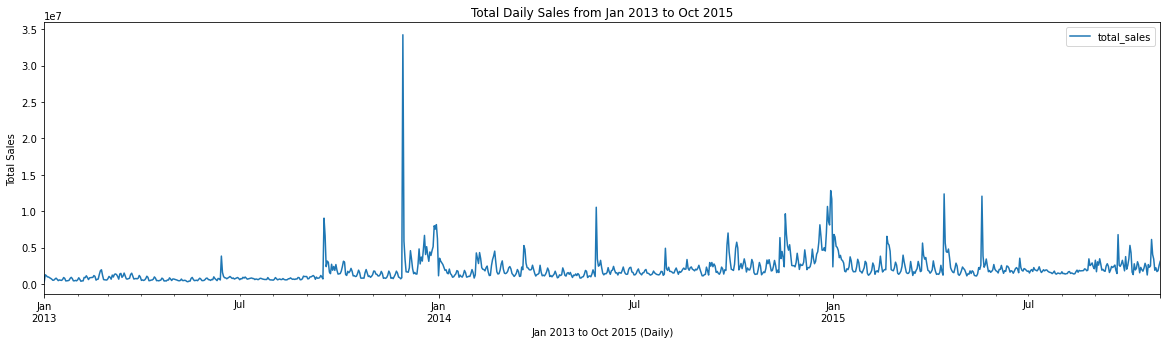

In [7]:
#plot daily line graph from jan 2013 to oct 2015
all_data_by_date = all_data[['date', 'total_sales']]

aggregations = {'total_sales':'sum'}
all_data_by_date = all_data_by_date.groupby(['date'], as_index=False).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)

ax = all_data_by_date.plot(x='date', y='total_sales', kind='line', figsize=(20,5))
ax.set_title('Total Daily Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Daily)")
ax.set_ylabel("Total Sales")

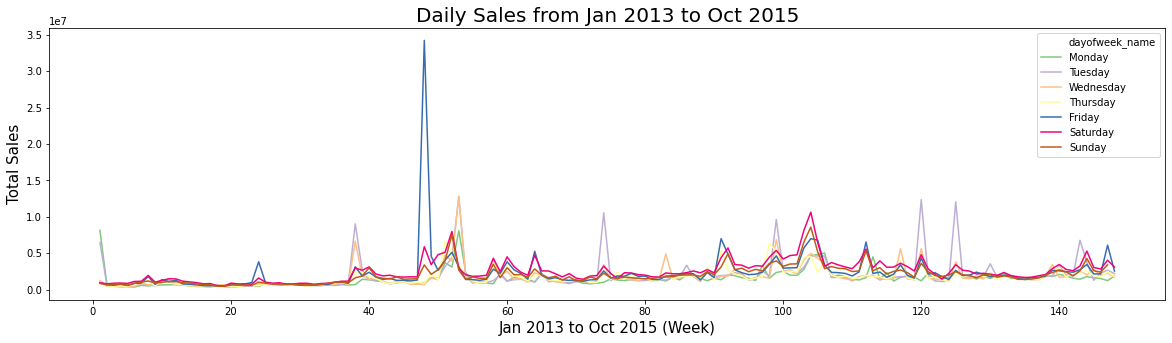

In [8]:
#plot graph of the historical data by grouping data of the day
all_data_weekday1 = all_data.loc[(all_data['dayofweek_name'] == 'Monday')]
all_data_weekday2 = all_data.loc[(all_data['dayofweek_name'] == 'Tuesday')]
all_data_weekday3 = all_data.loc[(all_data['dayofweek_name'] == 'Wednesday')]
all_data_weekday4 = all_data.loc[(all_data['dayofweek_name'] == 'Thursday')]
all_data_weekday5 = all_data.loc[(all_data['dayofweek_name'] == 'Friday')]
all_data_weekday6 = all_data.loc[(all_data['dayofweek_name'] == 'Saturday')]
all_data_weekday7 = all_data.loc[(all_data['dayofweek_name'] == 'Sunday')]

all_data_weekday1 = all_data_weekday1.groupby(['dayofweek_name', 'wrk_week'])[['total_sales']].agg('sum').reset_index()#.sort_values(['year', 'week'], ascending=[True,True])
all_data_weekday2 = all_data_weekday2.groupby(['dayofweek_name', 'wrk_week'])[['total_sales']].agg('sum').reset_index()#.sort_values(['year', 'week'], ascending=[True,True])
all_data_weekday3 = all_data_weekday3.groupby(['dayofweek_name', 'wrk_week'])[['total_sales']].agg('sum').reset_index()#.sort_values(['year', 'week'], ascending=[True,True])
all_data_weekday4 = all_data_weekday4.groupby(['dayofweek_name', 'wrk_week'])[['total_sales']].agg('sum').reset_index()#.sort_values(['year', 'week'], ascending=[True,True])
all_data_weekday5 = all_data_weekday5.groupby(['dayofweek_name', 'wrk_week'])[['total_sales']].agg('sum').reset_index()#.sort_values(['year', 'week'], ascending=[True,True])
all_data_weekday6 = all_data_weekday6.groupby(['dayofweek_name', 'wrk_week'])[['total_sales']].agg('sum').reset_index()#.sort_values(['year', 'week'], ascending=[True,True])
all_data_weekday7 = all_data_weekday7.groupby(['dayofweek_name', 'wrk_week'])[['total_sales']].agg('sum').reset_index()#.sort_values(['year', 'week'], ascending=[True,True])
all_data_weekday = pd.concat([all_data_weekday1, all_data_weekday2, all_data_weekday3, all_data_weekday4, all_data_weekday5, all_data_weekday6, all_data_weekday7])

plt.rcParams['figure.figsize']=(20, 5)
sns.lineplot(x='wrk_week', y = 'total_sales', data = all_data_weekday, hue='dayofweek_name' , palette = 'Accent')
plt.title("Daily Sales from Jan 2013 to Oct 2015", fontsize = 20)
plt.xlabel("Jan 2013 to Oct 2015 (Week)", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.show()


Text(0, 0.5, 'Total Sales')

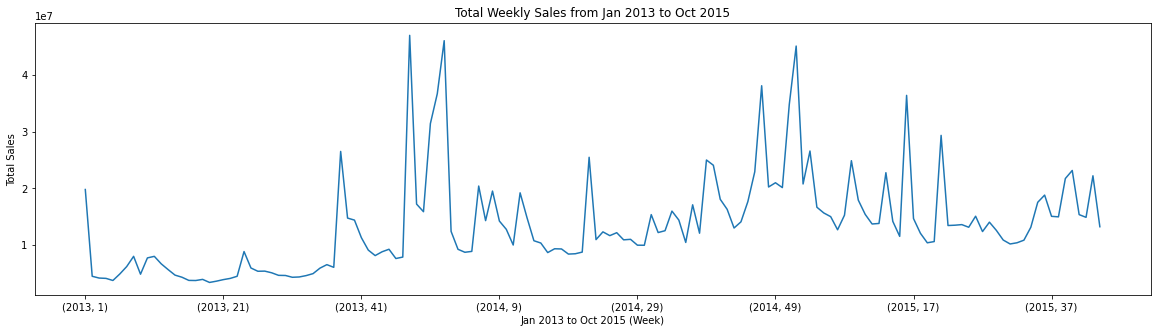

In [9]:
#plot weekly line graph from jan 2013 to oct 2015
all_data_by_week = all_data[['date', 'total_sales', 'date_week', 'date_year']]

aggregations = {'total_sales':'sum'}
all_data_by_week = all_data_by_week.groupby(['date_year', 'date_week']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)
ax = all_data_by_week['total_sales'].plot(figsize=(20,5))
ax.set_title('Total Weekly Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Week)")
ax.set_ylabel("Total Sales")

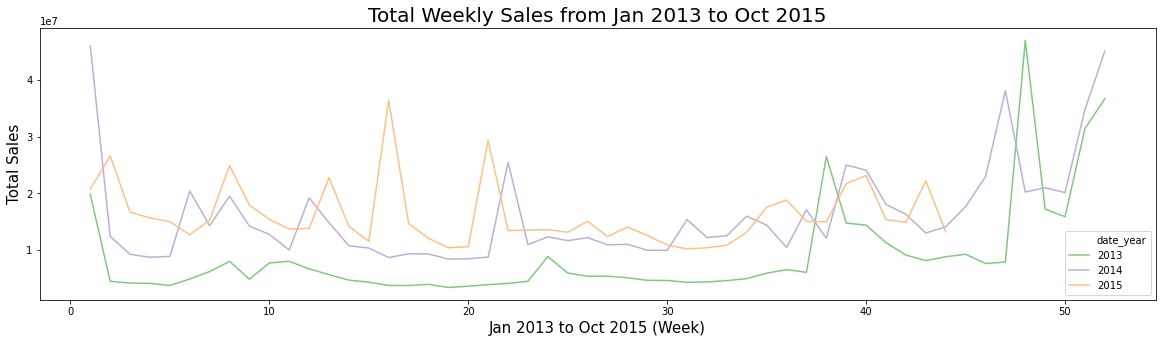

In [10]:
#plot weekly graph by year for better comparison
all_data_by_week = all_data.groupby(['date_week', 'date_year'])[['total_sales']].agg('sum').reset_index()
#all_data_agg


plt.rcParams['figure.figsize']=(20, 5)
sns.lineplot(x='date_week', y='total_sales', hue='date_year', data = all_data_by_week, palette='Accent')
plt.title("Total Weekly Sales from Jan 2013 to Oct 2015", fontsize = 20)
plt.xlabel("Jan 2013 to Oct 2015 (Week)", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
#plt.figure(figsize=(100, 6))
plt.show()

Text(0, 0.5, 'Total Sales')

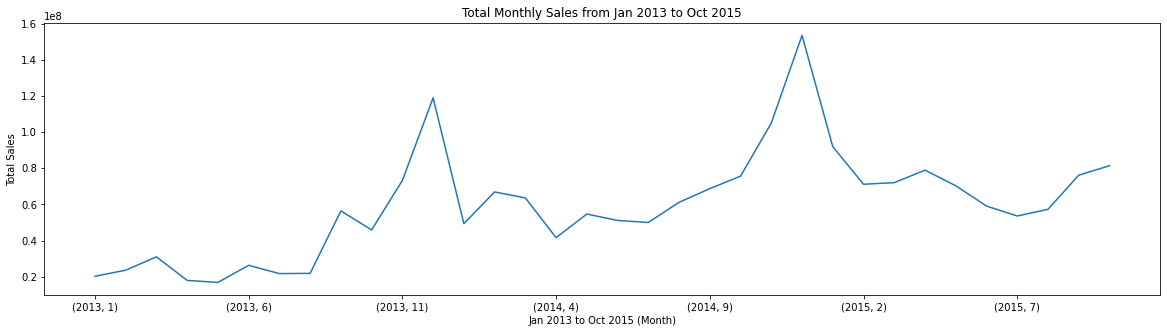

In [11]:
#plot monthly line graph from jan 2013 to oct 2015
all_data_by_month = all_data[['date', 'total_sales', 'date_month', 'date_year']]
#all_data_working

aggregations = {'total_sales':'sum'}
all_data_by_month = all_data_by_month.groupby(['date_year', 'date_month']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)
ax = all_data_by_month['total_sales'].plot(figsize=(20,5))
ax.set_title('Total Monthly Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Month)")
ax.set_ylabel("Total Sales")

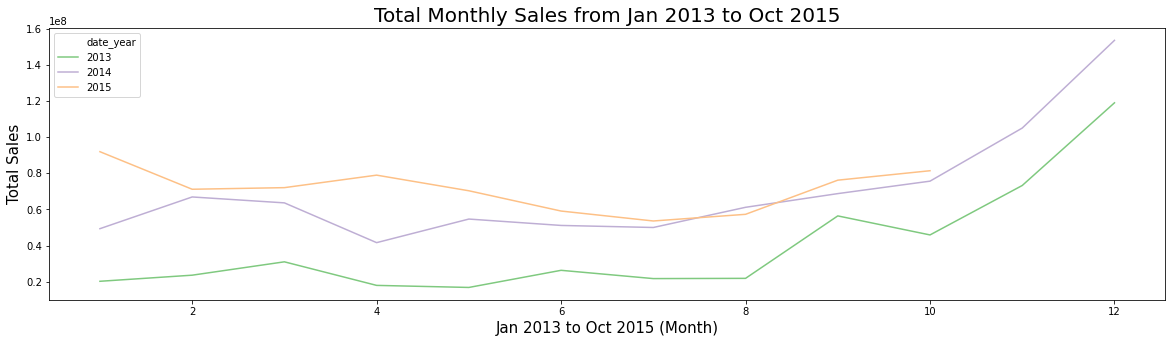

In [12]:
#plot monthly graph by year for better comparison
all_data_by_month = all_data.groupby(['date_month', 'date_year'])[['total_sales']].agg('sum').reset_index()
#all_data_agg

sns.lineplot(x='date_month', y='total_sales', hue='date_year', data = all_data_by_month, palette = 'Accent')
plt.rcParams['figure.figsize']=(20, 5)
plt.title("Total Monthly Sales from Jan 2013 to Oct 2015", fontsize = 20)
plt.xlabel("Jan 2013 to Oct 2015 (Month)", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.show()

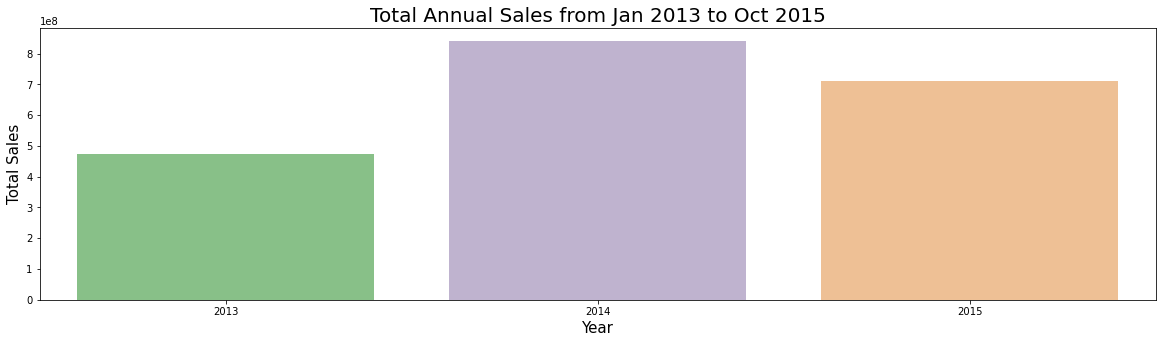

In [13]:
#plot graph by year
all_data_by_year = all_data.groupby(['date_year'])[['total_sales']].agg('sum').reset_index()
#all_data_agg

sns.barplot(x='date_year', y='total_sales', data = all_data_by_year, palette = 'Accent')
plt.title("Total Annual Sales from Jan 2013 to Oct 2015", fontsize = 20)
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
plt.show()

In [14]:
#construct the table by each day
all_data_by_weekday = all_data[['date', 'item_cnt_day', 'date_week', 'date_year', 'dayofweek_name', 'dayofweek_no']]
aggregations = {'item_cnt_day':'sum'}
all_data_by_weekday = all_data_by_weekday.groupby(['date_year', 'date_week', 'dayofweek_name', 'dayofweek_no']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.0f}'.format)
all_data_by_weekday.sort_values(by=['date_year', 'date_week', 'dayofweek_no', 'dayofweek_name'])

item_cnt_day
date_year date_week dayofweek_name dayofweek_no                     
2013      1         Monday         0                           6,268
                    Tuesday        1                           5,571
                    Wednesday      2                           1,788
                    Thursday       3                           1,622
                    Friday         4                           1,390
...                                                              ...
2015      44        Tuesday        1                           1,474
                    Wednesday      2                           3,555
                    Thursday       3                           1,535
                    Friday         4                           2,146
                    Saturday       5                           2,944

[1032 rows x 1 columns]

[Text(0, 0, '(2015, 16, Saturday, 5)'),
 Text(0, 0, '(2013, 1, Friday, 4)'),
 Text(0, 0, '(2013, 29, Thursday, 3)'),
 Text(0, 0, '(2014, 6, Monday, 0)'),
 Text(0, 0, '(2014, 34, Tuesday, 1)'),
 Text(0, 0, '(2015, 11, Tuesday, 1)'),
 Text(0, 0, '(2015, 40, Saturday, 5)'),
 Text(0, 0, '')]

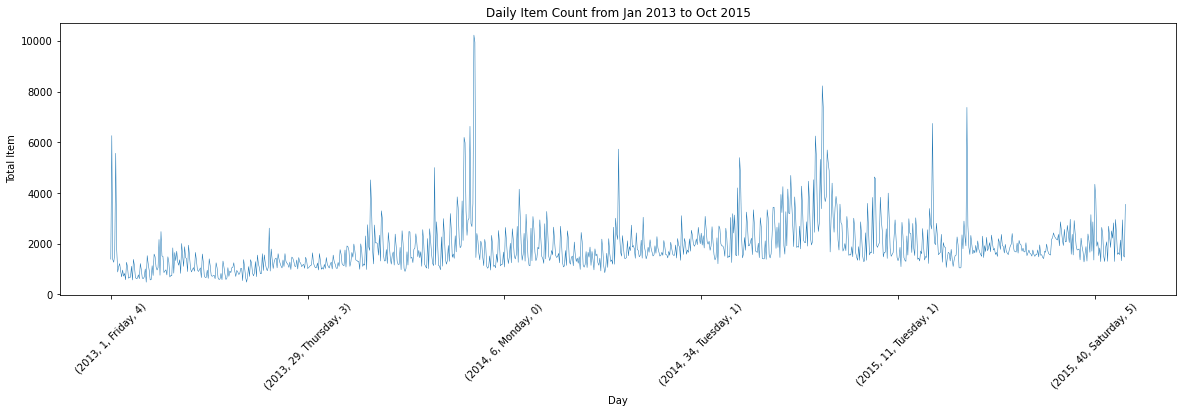

In [15]:
#construct the graph
ax = all_data_by_weekday['item_cnt_day'].plot(linewidth=0.5)
ax.set_title('Daily Item Count from Jan 2013 to Oct 2015')
ax.set_xlabel("Day")
ax.set_ylabel("Total Item")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

In [16]:
#lag feature - to be used as the bases for machine learning

all_data_by_day = all_data
aggregations = {'total_sales':'sum'}
all_data_by_day = all_data_by_day.groupby(['date'], as_index=False).agg(aggregations)
all_data_by_day['lag_1'] = all_data_by_day['total_sales'].shift(1)
all_data_by_day['lag_2'] = all_data_by_day['total_sales'].shift(2)
all_data_by_day['lag_3'] = all_data_by_day['total_sales'].shift(3)
all_data_by_day['lag_4'] = all_data_by_day['total_sales'].shift(4)
all_data_by_day['lag_5'] = all_data_by_day['total_sales'].shift(5)
all_data_by_day['lag_6'] = all_data_by_day['total_sales'].shift(6)
all_data_by_day['lag_7'] = all_data_by_day['total_sales'].shift(7)
all_data_by_day

,date,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2013-01-01,"286,396",nan,nan,nan,nan,nan,nan,nan
1,2013-01-02,"1,258,655","286,396",nan,nan,nan,nan,nan,nan
2,2013-01-03,"1,131,019","1,258,655","286,396",nan,nan,nan,nan,nan
3,2013-01-04,"965,669","1,131,019","1,258,655","286,396",nan,nan,nan,nan
4,2013-01-05,"955,023","965,669","1,131,019","1,258,655","286,396",nan,nan,nan
...,...,...,...,...,...,...,...,...,...
1029,2015-10-27,"2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586","2,289,480","2,659,224"
1030,2015-10-28,"1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586","2,289,480"
1031,2015-10-29,"1,822,707","1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586"
1032,2015-10-30,"2,551,906","1,822,707","1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958"


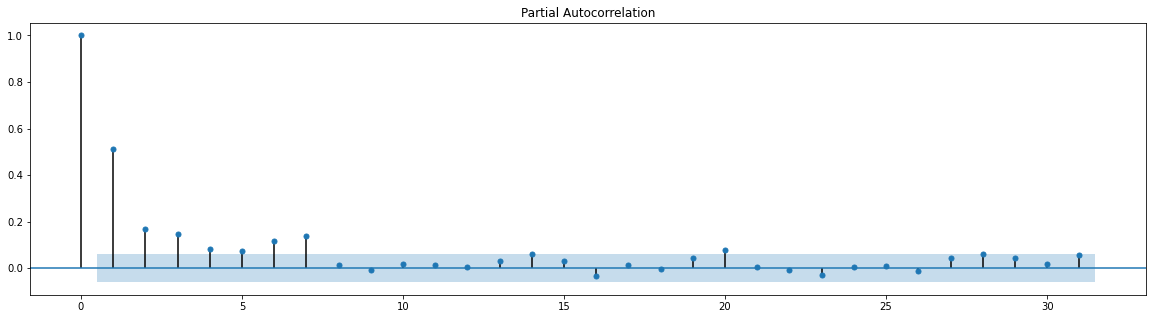

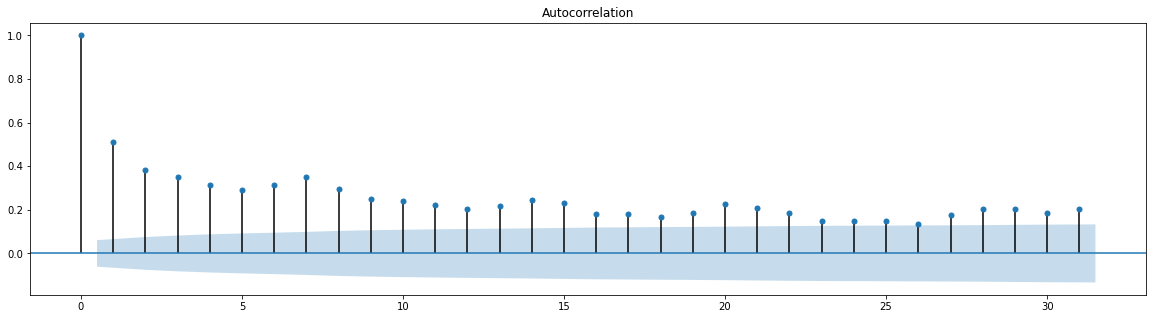

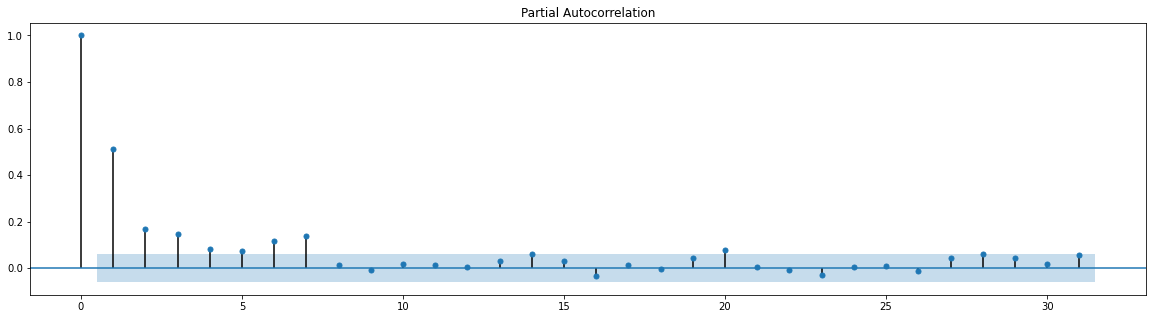

In [17]:
#plot autocorrelation and partial autocorrelation
#autocorrelation is a measure of the correlation between the lagged values of a time series
#partial autocorrelation is the correlation that results after removing the effect of any correlations due to the terms at shorter lags
plot_acf(all_data_by_day['total_sales'])
plot_pacf(all_data_by_day['total_sales'])

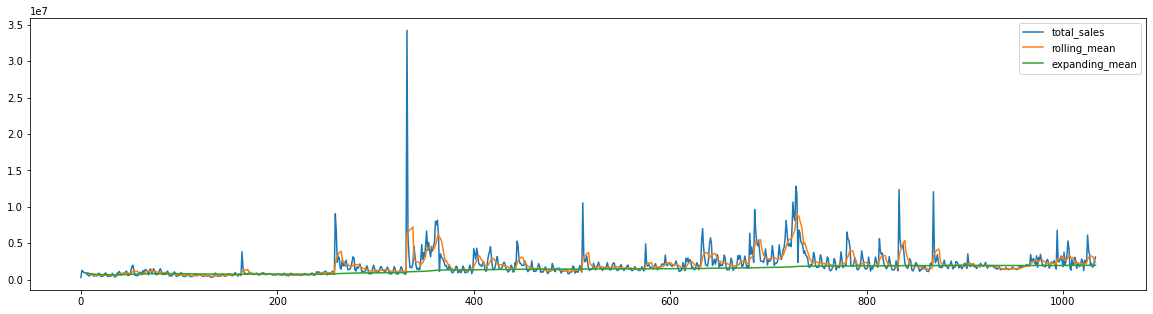

In [18]:
#construct the rolling mean, expanding mean of 7 days (1 week) compare with total sales
all_data_by_day['rolling_mean'] = all_data_by_day['total_sales'].rolling(window=7).mean()
all_data_by_day['expanding_mean'] = all_data_by_day['total_sales'].expanding(7).mean()
all_data_by_day[['total_sales', 'rolling_mean', 'expanding_mean']].plot(figsize=(20, 5))

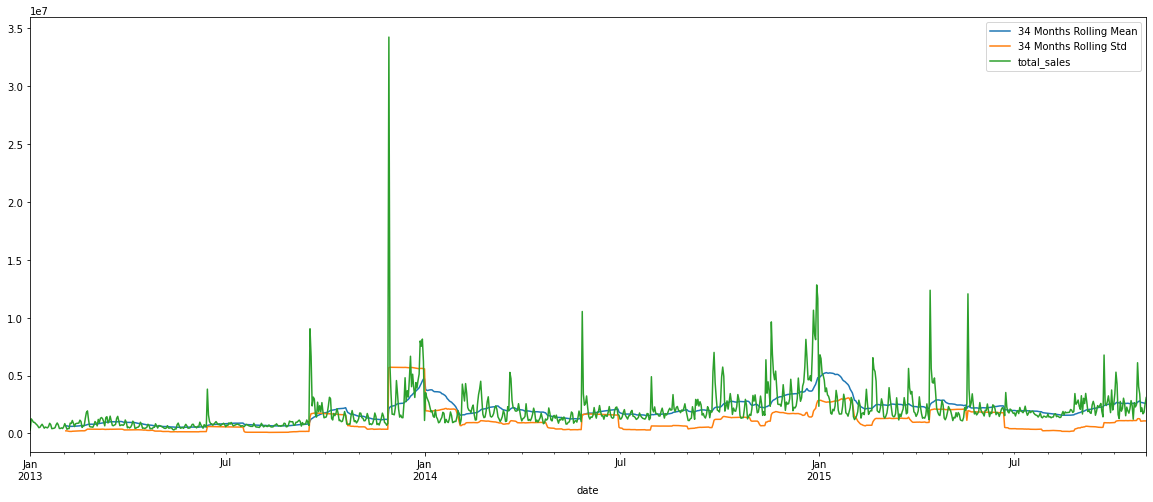

In [19]:
#rolling statistic to see the variation of mean and standard deviation
plt.rcParams['figure.figsize']=(20, 8)
all_data_by_day = all_data.groupby(['date']).agg(aggregations)
timeseries = all_data_by_day['total_sales']
timeseries.rolling(34).mean().plot(label='34 Months Rolling Mean')
timeseries.rolling(34).std().plot(label='34 Months Rolling Std')
timeseries.plot()
plt.legend()


<Figure size 1440x576 with 0 Axes>

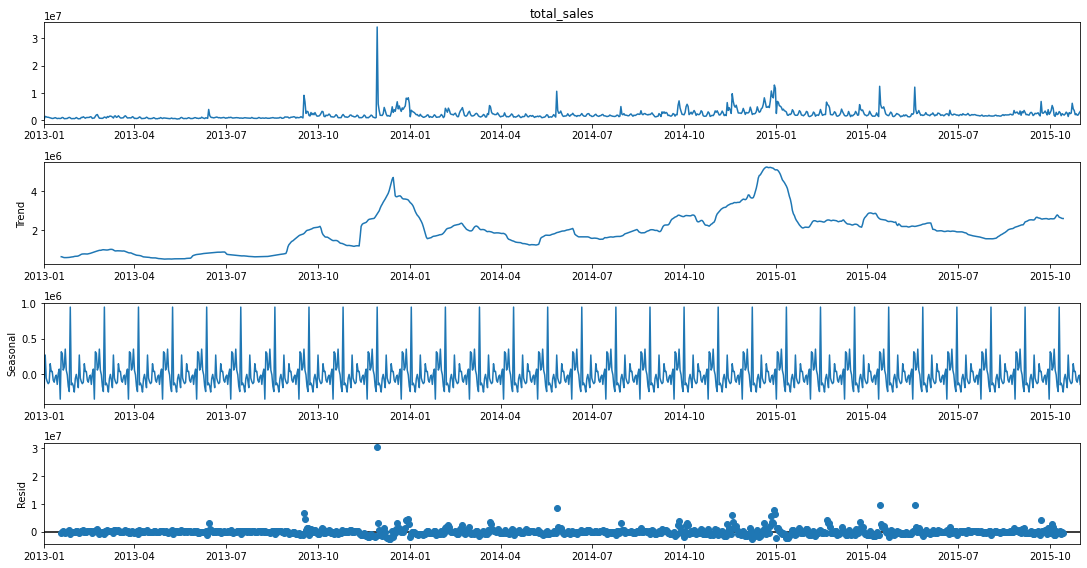

In [20]:
decomposition = seasonal_decompose(all_data_by_day['total_sales'], period=34)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(15, 8)
#the data is seasonal and there is an upward trend at the year end

In [21]:

test_result = adfuller(all_data_by_day['total_sales'])
print ('ADF Test:')
labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']

for value,label in zip(test_result,labels):
    print (label+': '+str(value))
if test_result [1] <= 0.05:
    print ("Reject null hypothesis and data is stationary")
else:
    print ("Fail to reject H0 thereby data is non-stationary ")


ADF Test:
ADF Statistic: -6.09229291052695
p-value: 1.0295633519118959e-07
No. of Lags Used: 6
Number of Observations Used: 1027
Reject null hypothesis and data is stationary


In [22]:
model = sm.tsa.statespace.SARIMAX(all_data_by_day['total_sales'],order=(0,1,0), seasonal_order=(1,1,1,12))
ARIMAresult = model.fit()
print (ARIMAresult.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                          total_sales   No. Observations:                 1034
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood              -16200.672
Date:                              Tue, 05 Jan 2021   AIC                          32407.344
Time:                                      22:47:20   BIC                          32422.130
Sample:                                  01-01-2013   HQIC                         32412.958
                                       - 10-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0381      0.099     -0.386      0.700      -0.231       0.155
ma.S.L12      -0.97

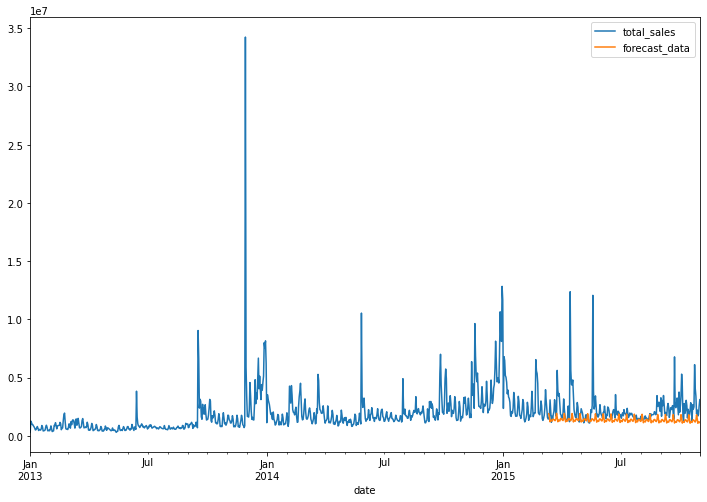

In [23]:
all_data_by_day['forecast_data'] = ARIMAresult.predict(start = 800, end= 1200, dynamic= True)  
all_data_by_day [['total_sales','forecast_data']]. plot (figsize= (12,8))

date
2013-01-01                    nan
2013-01-02                    nan
2013-01-03                    nan
2013-01-04                    nan
2013-01-05                    nan
2013-01-06                    nan
2013-01-07                887,370
2013-01-08                940,140
2013-01-09                831,353
2013-01-10                745,291
Name: total_sales, dtype: float64


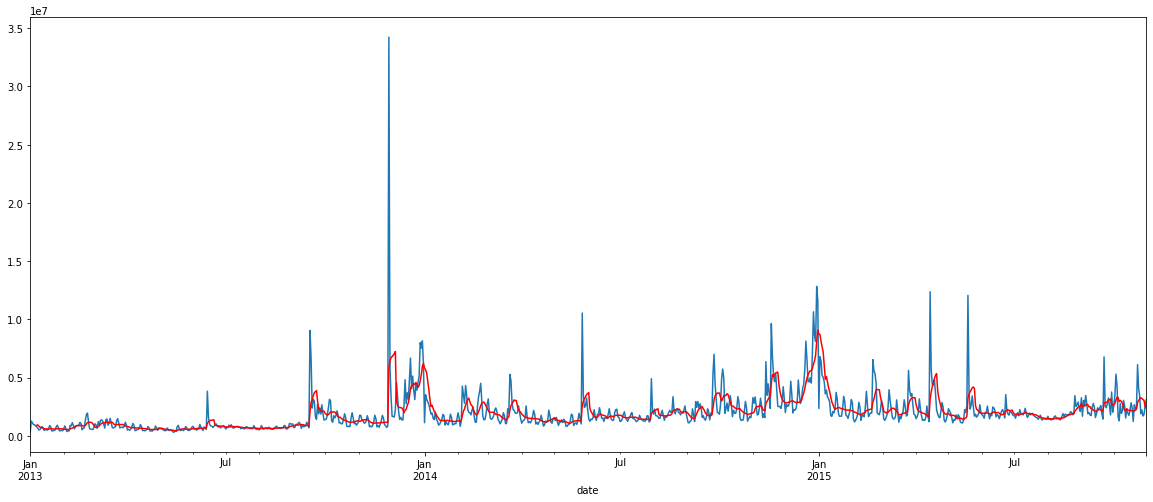

In [24]:
#moving average with a window size of 7 days
timeseries = all_data_by_day['total_sales']
rolling = timeseries.rolling(window=7)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
timeseries.plot()
rolling_mean.plot(color='red')
plt.show()

<Figure size 1440x576 with 0 Axes>

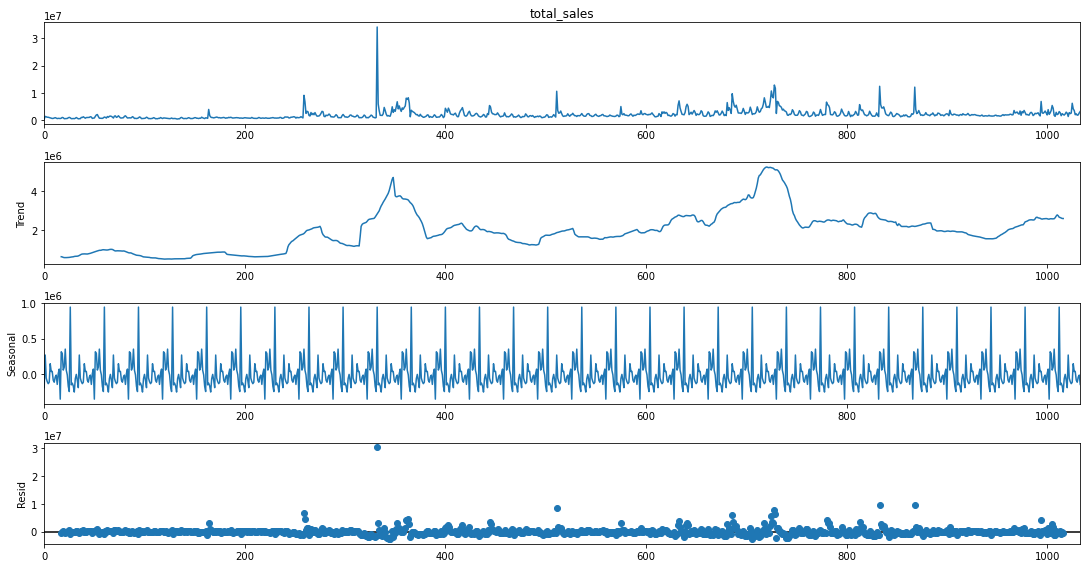

In [25]:
all_data_by_day = all_data
aggregations = {'total_sales':'sum'}
all_data_by_day = all_data_by_day.groupby(['date'], as_index=False).agg(aggregations)

decomposition = seasonal_decompose(all_data_by_day['total_sales'], period=34)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(15, 8)

## Model predicting using Holt’s Linear Trend Method and Holt-Winters’ Seasonal Method

In [26]:
all_data_by_day['date'] = pd.to_datetime(all_data_by_day['date'])
all_data_by_day = all_data_by_day.set_index('date')
all_data_by_day = all_data_by_day['2013-01-01':'2015-10-31'].resample('D').sum()
all_data_by_day

,total_sales
date,
2013-01-01,"286,396"
2013-01-02,"1,258,655"
2013-01-03,"1,131,019"
2013-01-04,"965,669"
2013-01-05,"955,023"
...,...
2015-10-27,"2,211,635"
2015-10-28,"1,696,390"
2015-10-29,"1,822,707"


In [27]:
y_to_train = all_data_by_day[:'2015-05-31'] # dataset to train
y_to_val = all_data_by_day['2015-06-01':] # last X months for test  
predict_date = len(all_data_by_day) - len(all_data_by_day[:'2015-06-01']) # the number of data points for the test set


In [28]:
#train = pd.read_csv(r'C:/Testing/DA/predictFutureSalesClean.csv')

In [29]:
# Only keep date & item_cnt_day
Forecast_IP = train[['date','item_cnt_day']]
Forecast_IP['date'] = pd.to_datetime(Forecast_IP['date'])
# Set date as index
Forecast_IP = Forecast_IP.set_index('date')
## Select time period for weekly aggregation
Forecast_IP_weekly = Forecast_IP['2013-01-01':'2015-10-31'].resample('W').sum()
Forecast_IP_weekly

<ipython-input-29-5835c219f514>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Forecast_IP['date'] = pd.to_datetime(Forecast_IP['date'])


,item_cnt_day
date,
2013-01-06,"7,891"
2013-01-13,"6,505"
2013-01-20,"5,755"
2013-01-27,"6,125"
2013-02-03,"5,551"
...,...
2015-10-04,"17,857"
2015-10-11,"12,808"
2015-10-18,"14,922"


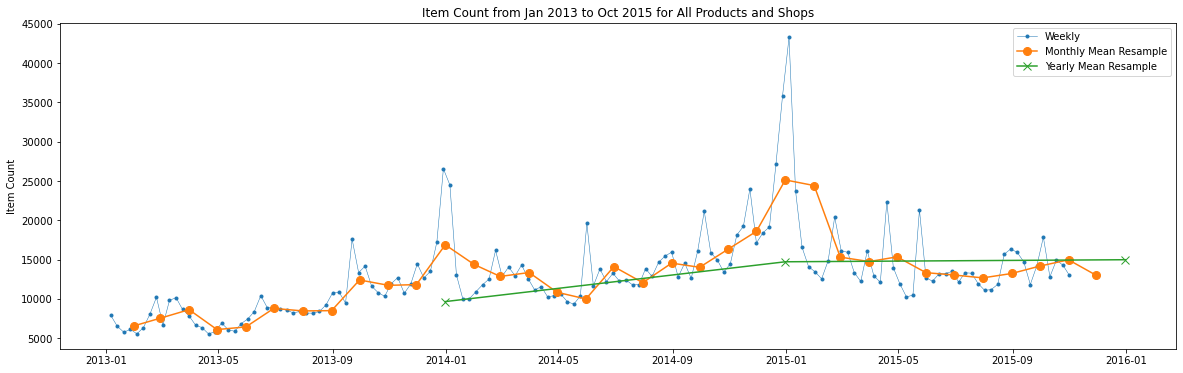

In [30]:
y = Forecast_IP_weekly['item_cnt_day']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),marker='x', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Item Count')
ax.set_title('Item Count from Jan 2013 to Oct 2015 for All Products and Shops')
ax.legend();

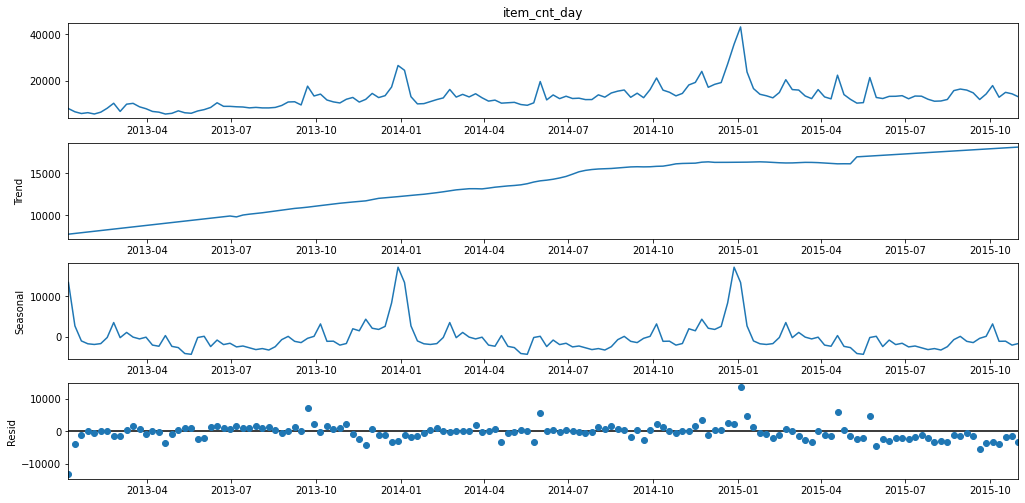

In [31]:


# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(y)

In [32]:
normData_filtered = train[['date','item_cnt_day','item_category_id']]

In [33]:

#create unique list of names
UniqueNames = normData_filtered.item_category_id.unique()

#create a data frame dictionary to store your data frames
df = {elem : pd.DataFrame for elem in UniqueNames}

for key in df.keys():
    df[key] = normData_filtered[:][normData_filtered.item_category_id == key]

In [34]:
count=0
for elem in df:
    count+=1
print('Total Item Category is {}'.format(count))

Total Item Category is 60


In [35]:
# Only keep date & item_cnt_day
Forecast_IP_item20 = df[20][['date','item_cnt_day']]
Forecast_IP_item20['date'] = pd.to_datetime(Forecast_IP_item20['date'])
# Set date as index
Forecast_IP_item20 = Forecast_IP_item20.set_index('date')
## Select time period for weekly aggregation
Forecast_IP_item20_weekly = Forecast_IP_item20['2013-01-01':'2015-10-31'].resample('W').sum()
Forecast_IP_item20_weekly

<ipython-input-35-82b882e204ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Forecast_IP_item20['date'] = pd.to_datetime(Forecast_IP_item20['date'])


,item_cnt_day
date,
2013-11-24,65
2013-12-01,"1,680"
2013-12-08,725
2013-12-15,453
2013-12-22,792
...,...
2015-10-04,941
2015-10-11,"1,233"
2015-10-18,"1,436"


In [36]:
## Validate the start date of item category 20
df_validate = train.loc[train['item_category_id']==20]
df_validate= df_validate.sort_values(by='date')

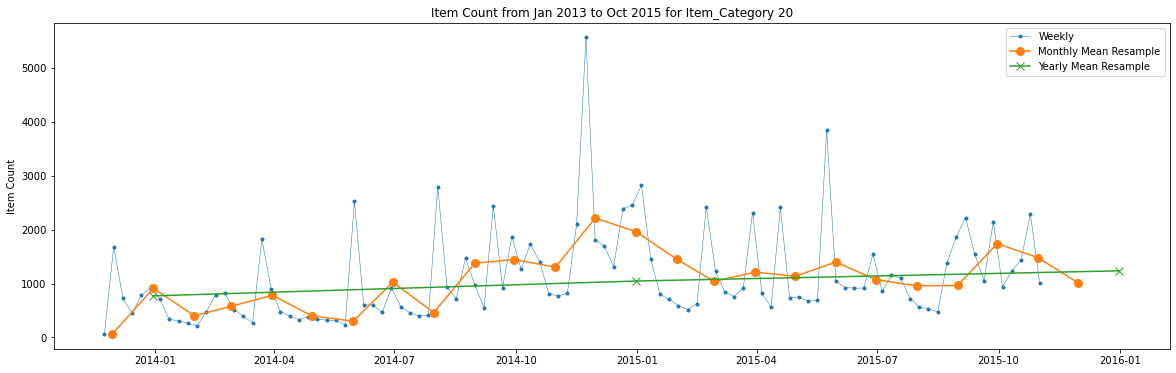

In [37]:
y = Forecast_IP_item20_weekly['item_cnt_day']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),marker='x', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Item Count')
ax.set_title('Item Count from Jan 2013 to Oct 2015 for Item_Category 20')
ax.legend();

In [38]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y,model='additive', freq=30)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [39]:
# Check the date at 70% of the dataset
Forecast_IP_item20_weekly.iloc[int(len(y)*0.7)]

item_cnt_day                    820
Name: 2015-04-05 00:00:00, dtype: float64

In [40]:
y_to_train = y[:'2015-04-05'] # dataset to train
y_to_val = y['2015-04-06':] # last X months for test  
predict_date = (len(y) - len(y[:'2015-04-06'])) # the number of data points for the test set

In [41]:
predict_date

30

## Holt’s Linear Trend Method

Holt method helps to forecast time series data that has a trend by expanding the SES method. SES method introduces level smooting parameter (α) and Holt methods introduces trend smoothing parameter (β*). 
Both parameters (α and β*) are in the range between 0 to 1. 

There are 2 Holt's model. 
1. Holt's additive model
2. Exponential model

Exponential model is not discussed in here as it is more appropriate for situations where the increase or decrease starts slowly at the beginning and then accelrates rapidly later. 


In [42]:




def holt(y, y_to_train,y_to_test,smoothing_level, smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's Liner Trend")
    # specific smoothing level
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    
    plt.show()



The Root Mean Squared Error of Holts Linear trend 723.94


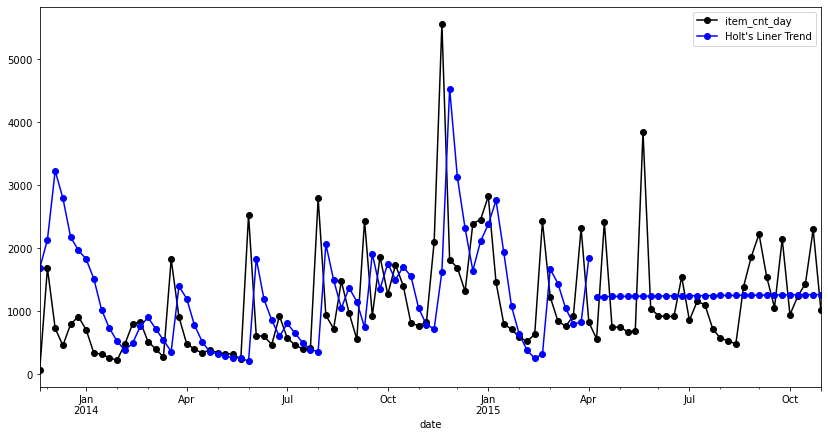

In [43]:
plt.figure()
holt(y, y_to_train, y_to_val, 0.6, 0.2, predict_date)

## Holt-Winters' Seasonal Method

The Holt-Winters model extends from Holt Linear method to allow the forecasting of time series data that has both trend and seasonaility. This method introduces seasonality smoothing parameter: γ

There are 2 types of seasonality
1. Additive - Seasonal changes in the data stay roughly the same over time and don't fluctuate in relation to the overall data
2. Multiplicative - Seasonal variation changes in relation to the overal changes in the data. Thus, if the data is trending upward, the seasonal differences grow proportionally as well. 

As the seasonality of our data is additive, thus, we will only discuss additive seasonality here. 

In [44]:


def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()
        
        


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=20 and a Box-Cox transformation 1013.12
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=20 and a Box-Cox transformation 819.34


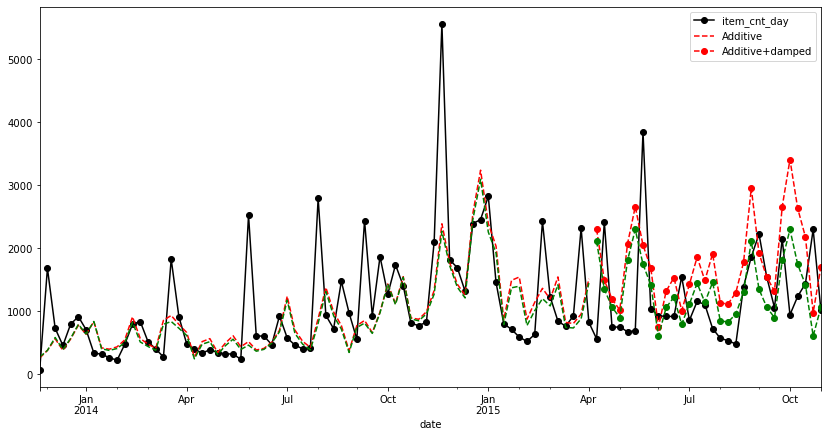

In [45]:
holt_win_sea(y, y_to_train,y_to_val,'additive',20, predict_date)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1071289                alpha                 True
smoothing_slope               2.762e-35                 beta                 True
smoothing_seasonal           1.7363e-20                gamma                 True
initial_level                 1018.3605                  l.0                 True
initial_slope                 8.3570866                  b.0                 True
initial_seasons.0            -492.86225                  s.0                 True
initial_seasons.1            -446.93824                  s.1                 True
initial_seasons.2            -793.44730                  s.2                 True
initial_seasons.3            -390.42197                  s.3                 True
initial_seasons.4            -180.47744                  s.4                 True
initial_seasons.

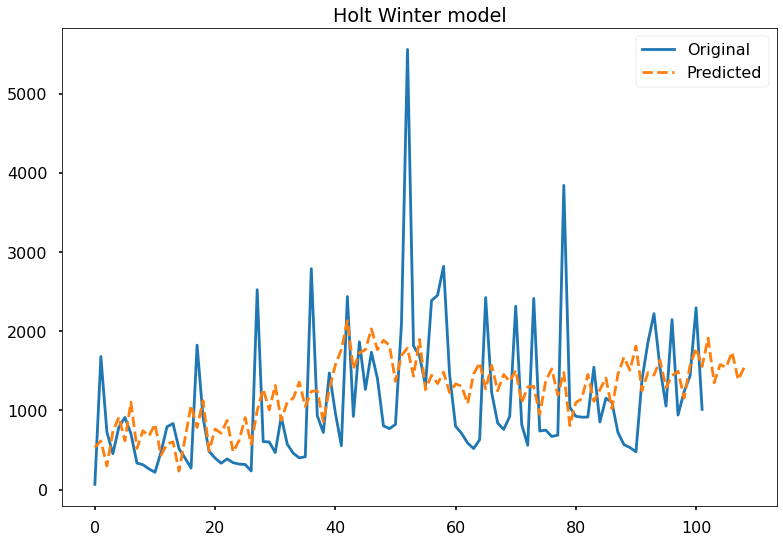

In [46]:
# Holt-Winters’ Seasonal Method  
model = HWES(y, seasonal_periods=12, trend='add', seasonal='add')
model_fit = model.fit()
print(model_fit.summary().tables[1])

# make prediction
yhat = model_fit.predict(12, len(y)+18) # predict N ahead of the last one

dataList = list(y)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(yhatList, ls='--', label='Predicted')
plt.legend(loc='best')
plt.title('Holt Winter model')
plt.show()


In [47]:
# Evaluation Score

rmse = sqrt(mean_squared_error(dataList,yhatList[0:102]))
print('Holt Winter RMSE: %.1f' % rmse)

mae = mean_absolute_error(dataList,yhatList[0:102])
print('Holt Winter MAE: %.1f' % mae)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(dataList,yhatList[0:102])
print('Holt Winter MAPE: %.1f' % mape)

Holt Winter RMSE: 767.5
Holt Winter MAE: 576.2
Holt Winter MAPE: 78.1


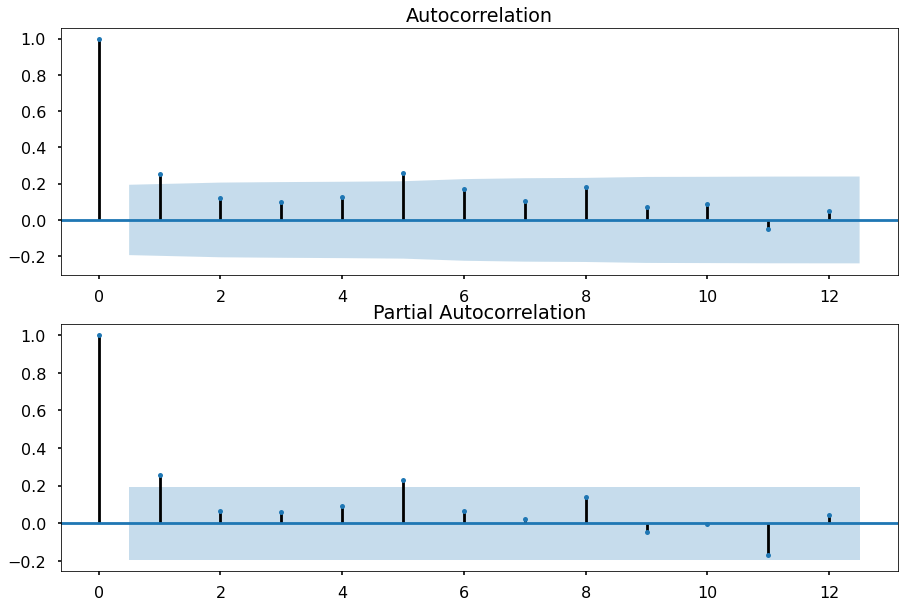

In [48]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
# Get p and q for Holt Winter

plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y, lags=12, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y, lags=12, ax=ax)
#plt.tight_layout()
plt.show()